#Stock Level Recommendation System Summary
##Objective:
To optimize stock levels for each vending machine and product based on sales trends, current stock levels, restocking frequencies, and logistics constraints, while ensuring minimum stockouts and avoiding overstocking. This system will assist AGPG in becoming more competitive by making more accurate, data-driven decisions for product orders and restocking.

##Workflow Overview:
###1. Data Preparation
Data Source: The dataset contains sales transactions with key attributes like *Machine ID, Product Name, Location Type, Date, Units Sold, Current Stock Level, Lead Time, etc.*
Purpose: This dataset allows us to track sales per product per vending machine over time, enabling precise stock-level calculations for future restocks.
###2. Calculate Average Daily Sales
For Each Machine and Product:
Total Units Sold: Calculate the total units sold per product across a given period.
Active Days: Count the number of unique active days for each product (days when it was sold).

Avg_Daily_Sales = *Total_Units_Sold / Active_Days*

  This gives us an accurate picture of daily sales rates.
###3. Merge Operational Factors
Lead Time: The number of days required to restock. This is calculated per machine and product combination based on historical supply chain data.
Restock Frequency: For example, restock might occur every 5 days depending on machine demand.

Restock_Frequency_Days = *12 / Avg_Daily_Sales*

  This ensures that products are ordered at a frequency based on actual sales trends, balancing stock availability and shelf space.
###4. Apply Safety Stock Buffer
Safety Stock: A 20% buffer (or a dynamic percentage based on sales volatility) is applied to the recommended stock level to prevent stockouts during demand surges or supply chain delays.

*Safety_Stock = Avg_Daily_Sales × 0.2*
###5. Final Recommended Stock Level Formula

Recommended_Stock_Level = *(Avg_Daily_Sales × (Restock_Frequency_Days + Lead_Time_Days)) + Safety_Stock* <br>

Purpose: This formula ensures sufficient stock to meet demand until the next restocking, accounting for both the lead time and safety stock buffer.
Output & Visualization
###6. Grouped Results
Results show the Recommended Stock Levels per:
Machine ID: Unique identifier for each vending machine.
Location Type: For example, busy locations like Changi Airport or quieter locations like East Coast Park.
Product Name: Different product categories like soft drinks, juices, etc.
###7. Visualizations
Bar Charts for Each Machine: Each machine will have a bar chart showing the recommended stock levels per product.
Value Labels: Each bar will display the recommended order quantity.
Order Table: A detailed order table showing the current stock, recommended stock, and order quantity for each product in each machine.
Restock Date: The projected next restock date for each machine will be displayed based on the calculated restocking frequency.

In [1]:
## Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Importing the data
The data includes 15 types of popular drinks sold in vending machines in Singapore, and are sold at 5 different vending machines at different locations across the country.

In [2]:
#Create pandas dataframe from CSV

drinks = pd.read_csv('dataset/Vending_Machine_Sales_Data_Singapore.csv')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print(drinks)


     Machine_ID                    Location_Type        Date Product_ID       Product_Name  Category  Units_Sold  Current_Stock_Level  Stockout_Flag Day_of_Week  Event_Flag  Lead_Time_Days
0          M004          Khoo Teck Puat Hospital  2025-02-08        P03             Sprite      Soda           4                    4              0    Saturday           0               3
1          M005                  East Coast Park  2025-01-11        P15    Lipton Iced Tea       Tea           2                    7              0    Saturday           0               2
2          M004          Khoo Teck Puat Hospital  2025-01-24        P07  Yeo’s Grass Jelly    Herbal           3                    4              0      Friday           0               1
3          M001                   Changi Airport  2025-02-13        P04              Fanta      Soda           6                   10              0    Thursday           0               3
4          M003  Singapore Management University  2025-

In [3]:
#Describe the data
drinks.describe(include='all')

,Machine_ID,Location_Type,Date,Product_ID,Product_Name,Category,Units_Sold,Current_Stock_Level,Stockout_Flag,Day_of_Week,Event_Flag,Lead_Time_Days
count,5000,5000,5000,5000,5000,5000,5000.000000,5000.000000,5000.000000,5000,5000.000000,5000.000000
unique,5,5,59,15,15,6,NaN,NaN,NaN,7,NaN,NaN
top,M004,Khoo Teck Puat Hospital,2025-01-24,P09,Fuze Tea,Soda,NaN,NaN,NaN,Friday,NaN,NaN
freq,1024,1024,113,364,364,1722,NaN,NaN,NaN,784,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,5.081400,7.037800,0.143800,NaN,0.094600,2.004000
std,NaN,NaN,NaN,NaN,NaN,NaN,2.481049,4.322928,0.350922,NaN,0.292691,0.825421
min,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,0.000000,1.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,3.000000,0.000000,NaN,0.000000,1.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,7.000000,0.000000,NaN,0.000000,2.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,7.000000,11.000000,0.000000,NaN,0.000000,3.000000


In [7]:
import pandas as pd



# STEP 1: Total units sold per Machine + Product + Location
total_sales = drinks.groupby(['Machine_ID', 'Location_Type', 'Product_ID', 'Product_Name'])['Units_Sold'].sum().reset_index()
total_sales.rename(columns={'Units_Sold': 'Total_Units_Sold'}, inplace=True)

# STEP 2: Count unique active days per Machine + Product + Location
active_days = drinks.groupby(['Machine_ID', 'Location_Type', 'Product_ID'])['Date'].nunique().reset_index()
active_days.rename(columns={'Date': 'Active_Days'}, inplace=True)

# STEP 3: Merge total_sales and active_days on all relevant keys
sales_data = total_sales.merge(active_days, on=['Machine_ID', 'Location_Type', 'Product_ID'])

# STEP 4: Calculate Average Daily Sales
sales_data['Avg_Daily_Sales'] = (sales_data['Total_Units_Sold'] / sales_data['Active_Days']).round(2)

# STEP 5: Merge average Lead Time (machine + product level)
lead_time = drinks.groupby(['Machine_ID', 'Location_Type', 'Product_ID'])['Lead_Time_Days'].mean().reset_index()
sales_data = sales_data.merge(lead_time, on=['Machine_ID', 'Location_Type', 'Product_ID'])

# STEP 6: Dynamic Restock Frequency based on activity
sales_data['Restock_Frequency_Days'] = (12 / sales_data['Avg_Daily_Sales']).round().clip(lower=2, upper=10)

# STEP 7: Calculate Safety Stock (20% buffer)
sales_data['Safety_Stock'] = (sales_data['Avg_Daily_Sales'] * 0.2).round()

# STEP 8: Calculate Recommended Stock Level
sales_data['Recommended_Stock_Level'] = (
    sales_data['Avg_Daily_Sales'] * (sales_data['Restock_Frequency_Days'] + sales_data['Lead_Time_Days'])
    + sales_data['Safety_Stock']
).round()

# Merge Category info from drinks dataframe
category_lookup = drinks[['Product_ID', 'Category']].drop_duplicates()
sales_data = sales_data.merge(category_lookup, on='Product_ID', how='left')

# Create daily_sales DataFrame - group by Machine_ID, Product_ID, and Date
daily_sales = drinks.groupby(['Machine_ID', 'Date'])['Units_Sold'].sum().reset_index()

# Create machine_summary DataFrame
machine_summary = sales_data.groupby(['Machine_ID', 'Location_Type']).agg({
    'Recommended_Stock_Level': 'sum',
    'Restock_Frequency_Days': 'mean'
}).reset_index()
machine_summary.rename(columns={'Restock_Frequency_Days': 'Avg_Restock_Frequency_Days'}, inplace=True)

# Create machines DataFrame with unique Machine_ID and Location_Type
machines = drinks[['Machine_ID', 'Location_Type']].drop_duplicates()

# Convert the Date column to datetime objects
drinks['Date'] = pd.to_datetime(drinks['Date'])

# Convert dates in daily_sales if needed
daily_sales['Date'] = pd.to_datetime(daily_sales['Date'])

# STEP 9: Final Output
sales_data = sales_data[['Machine_ID', 'Location_Type','Product_ID','Product_Name', 'Category',
                         'Avg_Daily_Sales', 'Lead_Time_Days',
                         'Restock_Frequency_Days', 'Recommended_Stock_Level']]
print(sales_data.head(50))


   Machine_ID                    Location_Type Product_ID       Product_Name  Category  Avg_Daily_Sales  Lead_Time_Days  Restock_Frequency_Days  Recommended_Stock_Level
0        M001                   Changi Airport        P01          Coca-Cola      Soda            14.75        1.986667                     2.0                     62.0
1        M001                   Changi Airport        P02              Pepsi      Soda            14.09        1.952381                     2.0                     59.0
2        M001                   Changi Airport        P03             Sprite      Soda            12.05        2.000000                     2.0                     50.0
3        M001                   Changi Airport        P04              Fanta      Soda            12.27        2.029412                     2.0                     51.0
4        M001                   Changi Airport        P05            100Plus  Isotonic            13.26        2.045455                     2.0            

In [8]:
sales_data.head(100)

,Machine_ID,Location_Type,Product_ID,Product_Name,Category,Avg_Daily_Sales,Lead_Time_Days,Restock_Frequency_Days,Recommended_Stock_Level
0,M001,Changi Airport,P01,Coca-Cola,Soda,14.75,1.986667,2.0,62.0
1,M001,Changi Airport,P02,Pepsi,Soda,14.09,1.952381,2.0,59.0
2,M001,Changi Airport,P03,Sprite,Soda,12.05,2.000000,2.0,50.0
3,M001,Changi Airport,P04,Fanta,Soda,12.27,2.029412,2.0,51.0
4,M001,Changi Airport,P05,100Plus,Isotonic,13.26,2.045455,2.0,57.0
...,...,...,...,...,...,...,...,...,...
70,M005,East Coast Park,P11,A&W Root Beer,Soda,4.21,2.126984,3.0,23.0
71,M005,East Coast Park,P12,Nestea Iced Tea,Tea,4.00,1.806452,3.0,20.0
72,M005,East Coast Park,P13,Chrysanthemum Tea,Herbal,3.85,2.017241,3.0,20.0
73,M005,East Coast Park,P14,Nestle Teh Tarik,Tea,3.85,1.921569,3.0,20.0


AttributeError: 'str' object has no attribute 'strftime'

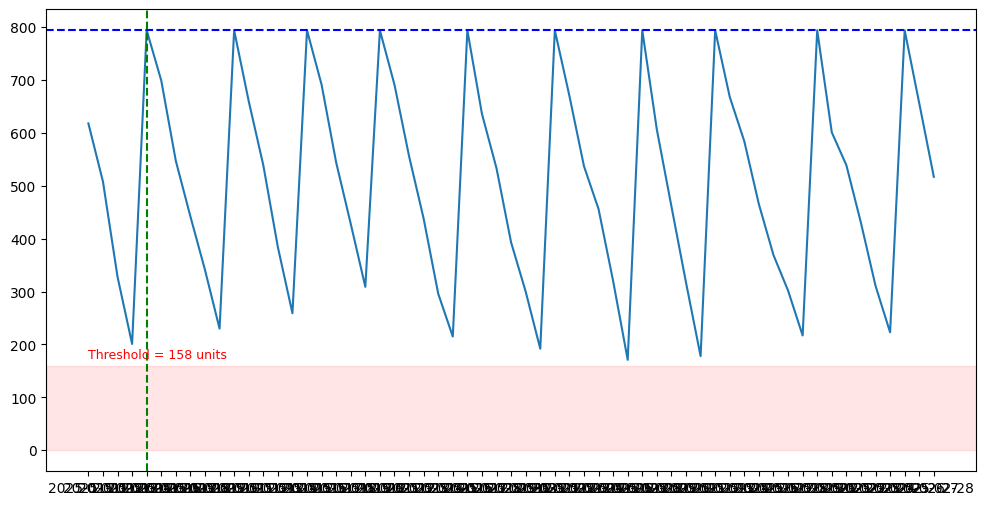

In [18]:
for idx, row in machine_summary.iterrows():
    machine_id = row['Machine_ID']
    location = row['Location_Type']
    rec_stock = row['Recommended_Stock_Level']
    threshold = 0.8 * rec_stock

    df_machine = daily_sales[daily_sales['Machine_ID'] == machine_id].sort_values('Date').copy()

    stock_level = []
    current_stock = rec_stock
    restock_dates = []

    for _, r in df_machine.iterrows():
        current_stock -= r['Units_Sold']
        if current_stock <= rec_stock - threshold:
            restock_dates.append(r['Date'])
            current_stock = rec_stock
        stock_level.append(current_stock)

    df_machine['Simulated_Stock'] = stock_level

    # Plot with annotations
    plt.figure(figsize=(12,6))
    plt.plot(df_machine['Date'], df_machine['Simulated_Stock'], label=f'Stock Level - {location}')

    # Recommended stock level line
    plt.axhline(y=rec_stock, color='blue', linestyle='--', label=f'Recommended Stock Level ({int(rec_stock)} units)')

    # Horizontal shaded region below threshold
    plt.axhspan(0, rec_stock - threshold, color='red', alpha=0.1, label='Below Threshold Zone')

    # Annotate threshold value
    plt.text(df_machine['Date'].min(), rec_stock - threshold + 10,
             f'Threshold = {int(rec_stock - threshold)} units',
             color='red', fontsize=9, va='bottom', ha='left')

    # Restock markers with date labels
    for restock_date in restock_dates:
        plt.axvline(x=restock_date, color='green', linestyle='--')
        plt.text(restock_date, (rec_stock - threshold) / 2, restock_date.strftime('%b %d'),
                 color='green', rotation=0, verticalalignment='bottom', fontsize=8)

    plt.title(f"Stock Level for {machine_id} - {location}")
    plt.xlabel('Date')
    plt.ylabel('Stock Level (Units)')
    plt.ylim(0, rec_stock * 1.2)
    plt.legend()
    plt.xticks(rotation=30, ha='right')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


/var/folders/0t/8k3yp31s0r7gfpr03z5mlt500000gn/T/ipykernel_79953/2866058239.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


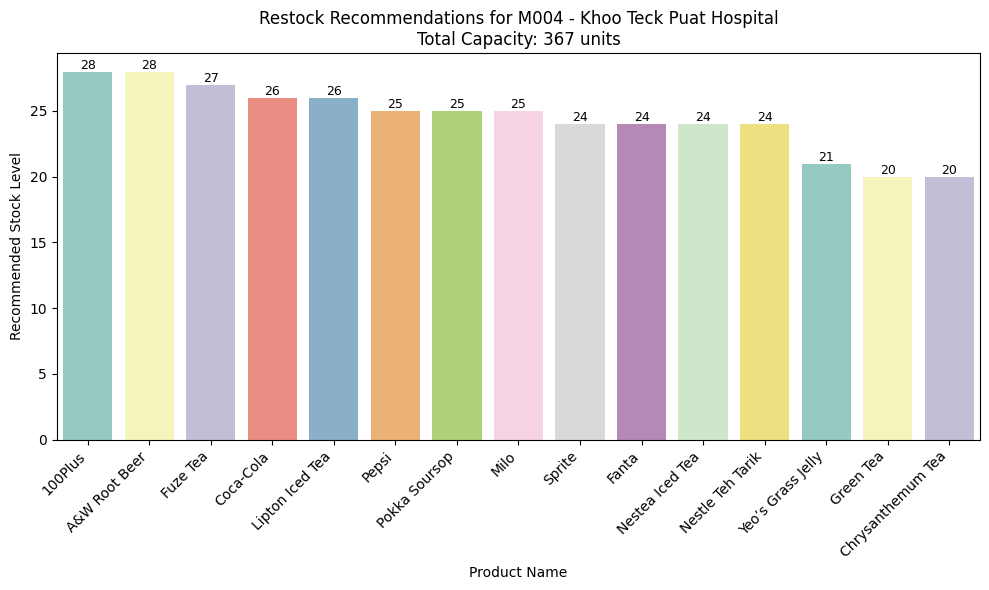

/var/folders/0t/8k3yp31s0r7gfpr03z5mlt500000gn/T/ipykernel_79953/2866058239.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


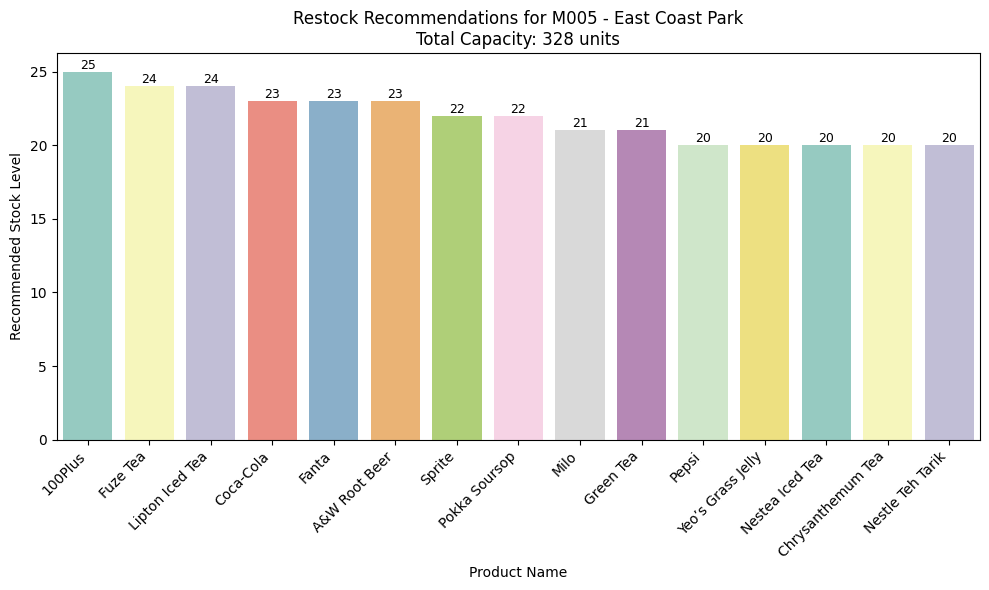

/var/folders/0t/8k3yp31s0r7gfpr03z5mlt500000gn/T/ipykernel_79953/2866058239.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


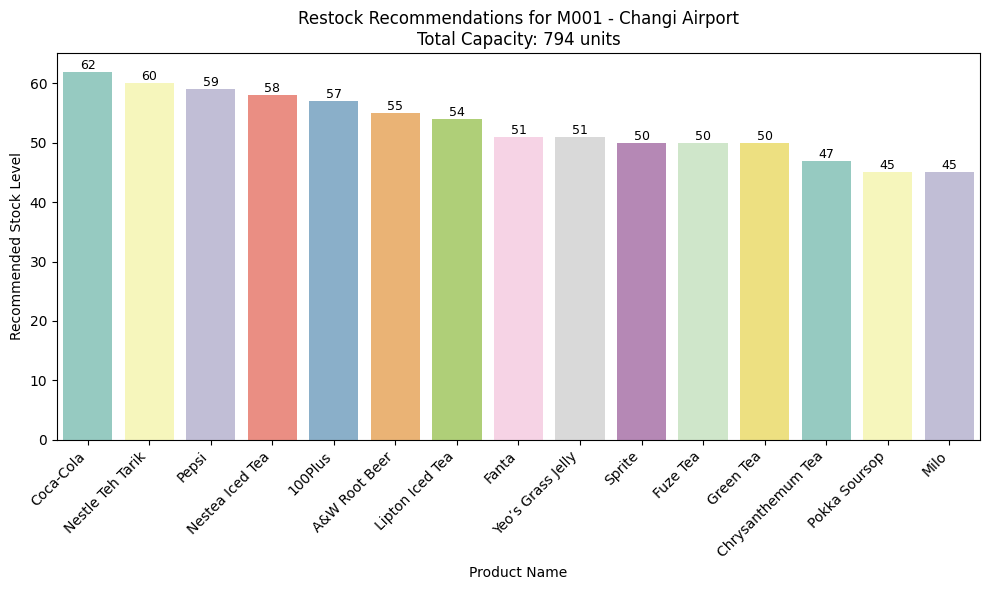

/var/folders/0t/8k3yp31s0r7gfpr03z5mlt500000gn/T/ipykernel_79953/2866058239.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


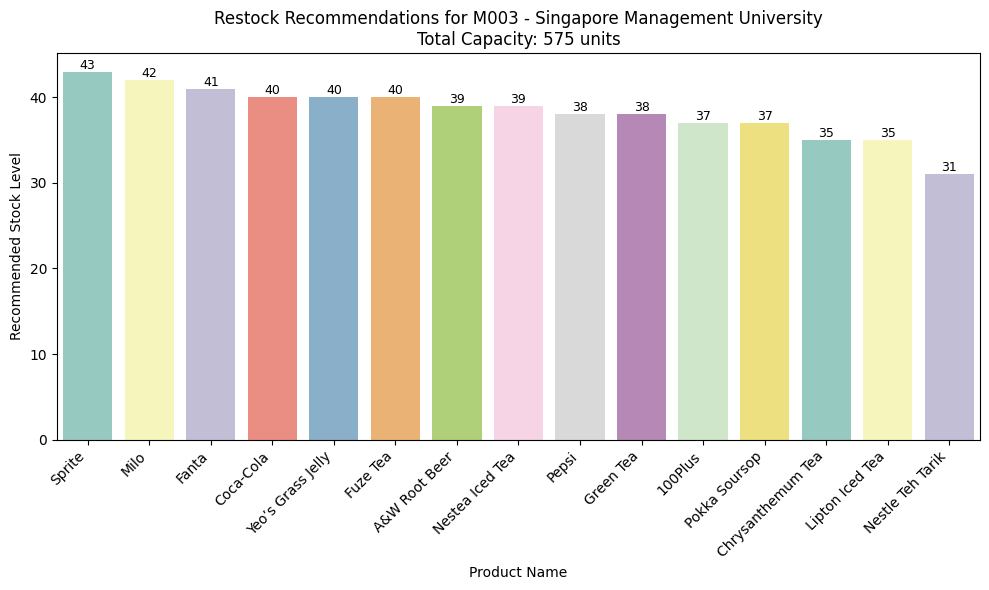

/var/folders/0t/8k3yp31s0r7gfpr03z5mlt500000gn/T/ipykernel_79953/2866058239.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


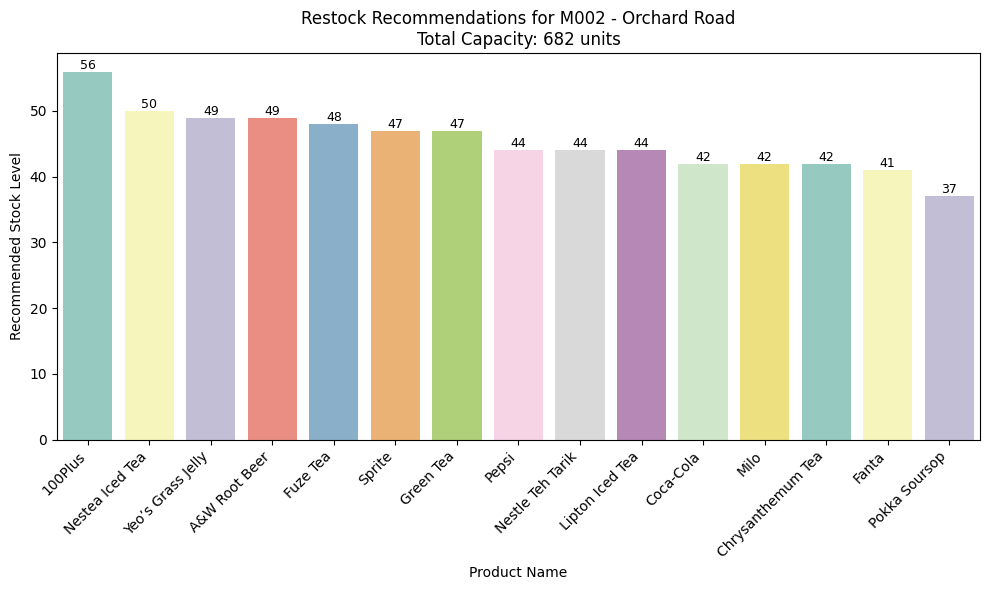

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

for _, row in machines.iterrows():
    machine_id = row['Machine_ID']
    location = row['Location_Type']

    subset = sales_data[sales_data['Machine_ID'] == machine_id].sort_values('Recommended_Stock_Level', ascending=False)
    total_capacity = subset['Recommended_Stock_Level'].sum()

    plt.figure(figsize=(10,6))
    sns.barplot(
        data=subset,
        x='Product_Name',
        y='Recommended_Stock_Level',
        palette='Set3',

    )

    for p in plt.gca().patches:
        plt.gca().annotate(
            f'{int(p.get_height())}',
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='bottom', fontsize=9
        )

    plt.title(f"Restock Recommendations for {machine_id} - {location}\nTotal Capacity: {int(total_capacity)} units", fontsize=12)
    plt.xlabel('Product Name')
    plt.ylabel('Recommended Stock Level')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


In [20]:
import pandas as pd
from datetime import timedelta, datetime

order_tables = []  # To store all machine-level dataframes

for _, row in machine_summary.iterrows():
    machine_id = row['Machine_ID']
    location = row['Location_Type']

    # Grab product-level recommendations
    machine_subset = sales_data[sales_data['Machine_ID'] == machine_id][['Product_Name', 'Product_ID', 'Category', 'Recommended_Stock_Level']].copy()

    # Get the latest CURRENT stock level from drinks dataset and round to whole numbers
    latest_stock = drinks[drinks['Machine_ID'] == machine_id].groupby('Product_ID')['Current_Stock_Level'].mean().reset_index()
    latest_stock['Current_Stock_Level'] = latest_stock['Current_Stock_Level'].round().astype(int)  # Round to whole number

    # Merge with recommended stock
    machine_subset = machine_subset.merge(latest_stock, on='Product_ID', how='left')

    # Calculate actual top-up requirement (ensure it's a whole number)
    machine_subset['Order_Quantity (Units)'] = (machine_subset['Recommended_Stock_Level'] - machine_subset['Current_Stock_Level']).clip(lower=0).round().astype(int)

    # Reformat table with additional columns
    machine_subset = machine_subset[['Product_Name', 'Category', 'Current_Stock_Level', 'Recommended_Stock_Level', 'Order_Quantity (Units)']]
    machine_subset = machine_subset.sort_values('Order_Quantity (Units)', ascending=False).reset_index(drop=True)

    # Calculate next restock date based on average restock frequency
    last_sale_date = pd.to_datetime(daily_sales[daily_sales['Machine_ID'] == machine_id]['Date'].max())  # Convert to datetime
    next_restock_date = last_sale_date + timedelta(days=int(row['Avg_Restock_Frequency_Days']))

    # Add machine, location, and next restock date
    machine_subset.insert(0, 'Machine_ID', machine_id)
    machine_subset.insert(1, 'Location', location)
    machine_subset.insert(2, 'Next_Restock_Date', next_restock_date.strftime('%Y-%m-%d'))  # Convert back to string format

    # Append to global list
    order_tables.append(machine_subset)

# Combine all tables into one dataframe
final_order_df = pd.concat(order_tables, ignore_index=True)
final_order_df

,Machine_ID,Location,Next_Restock_Date,Product_Name,Category,Current_Stock_Level,Recommended_Stock_Level,Order_Quantity (Units)
0,M001,Changi Airport,2025-03-02,Coca-Cola,Soda,7,62.0,55
1,M001,Changi Airport,2025-03-02,Nestle Teh Tarik,Tea,7,60.0,53
2,M001,Changi Airport,2025-03-02,Pepsi,Soda,8,59.0,51
3,M001,Changi Airport,2025-03-02,Nestea Iced Tea,Tea,7,58.0,51
4,M001,Changi Airport,2025-03-02,100Plus,Isotonic,7,57.0,50
...,...,...,...,...,...,...,...,...
70,M005,East Coast Park,2025-03-02,Pepsi,Soda,7,20.0,13
71,M005,East Coast Park,2025-03-02,Yeo’s Grass Jelly,Herbal,7,20.0,13
72,M005,East Coast Park,2025-03-02,Chrysanthemum Tea,Herbal,7,20.0,13
73,M005,East Coast Park,2025-03-02,Nestle Teh Tarik,Tea,7,20.0,13


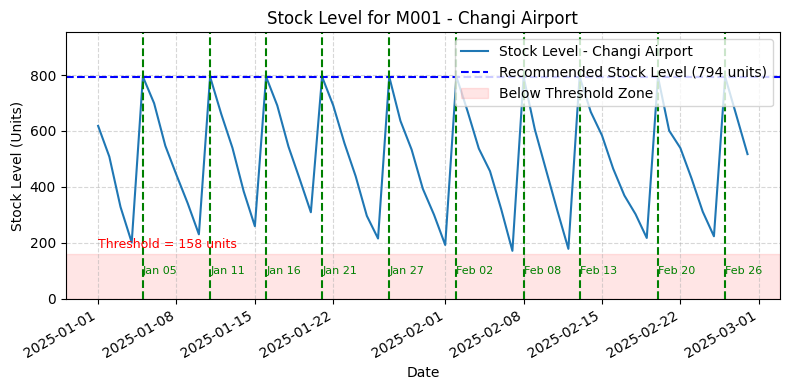

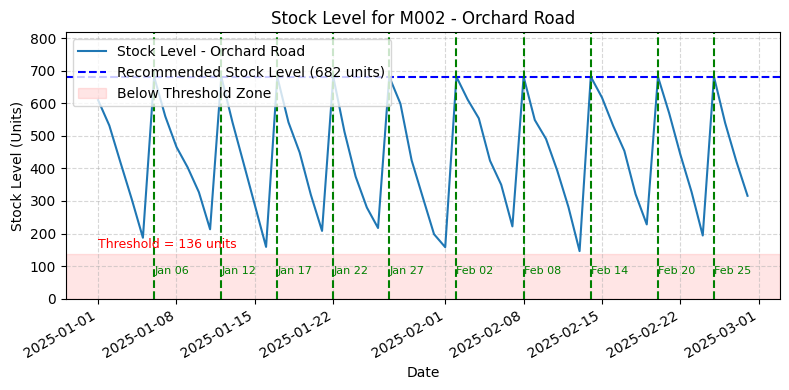

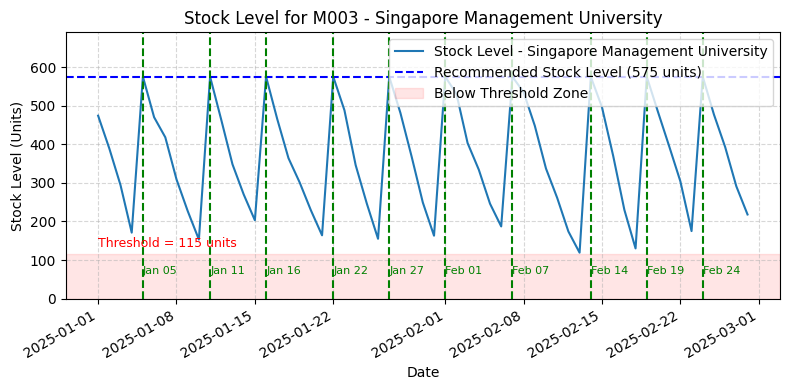

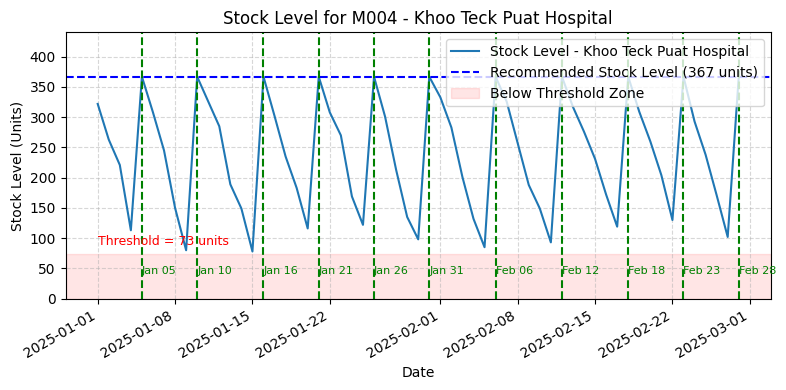

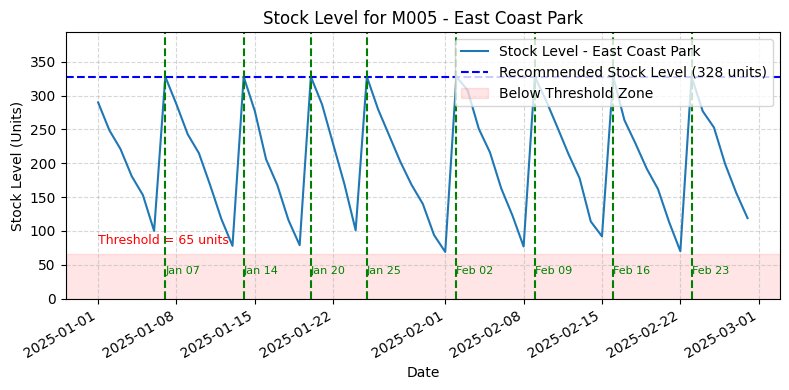

In [22]:
import pandas as pd  # Need pandas for pd.to_datetime
import datetime
import matplotlib.pyplot as plt

# Convert Date column to datetime first
daily_sales['Date'] = pd.to_datetime(daily_sales['Date'])

# Define the cutoff date for the last 3 months
cutoff_date = daily_sales['Date'].max() - datetime.timedelta(days=90)

for idx, row in machine_summary.iterrows():
    machine_id = row['Machine_ID']
    location = row['Location_Type']
    rec_stock = row['Recommended_Stock_Level']
    threshold = 0.8 * rec_stock

    df_machine = daily_sales[(daily_sales['Machine_ID'] == machine_id) &
                            (daily_sales['Date'] >= cutoff_date)].sort_values('Date').copy()

    stock_level = []
    current_stock = rec_stock
    restock_dates = []

    for _, r in df_machine.iterrows():
        current_stock -= r['Units_Sold']
        if current_stock <= rec_stock - threshold:
            restock_dates.append(r['Date'])  # This is already a datetime object
            current_stock = rec_stock
        stock_level.append(current_stock)

    df_machine['Simulated_Stock'] = stock_level

    # Plot with reduced width
    plt.figure(figsize=(8, 4))
    plt.plot(df_machine['Date'], df_machine['Simulated_Stock'], label=f'Stock Level - {location}')

    # Recommended stock level line
    plt.axhline(y=rec_stock, color='blue', linestyle='--', label=f'Recommended Stock Level ({int(rec_stock)} units)')

    # Horizontal shaded region below threshold
    plt.axhspan(0, rec_stock - threshold, color='red', alpha=0.1, label='Below Threshold Zone')

    # Annotate threshold value
    plt.text(df_machine['Date'].min(), rec_stock - threshold + 10,
             f'Threshold = {int(rec_stock - threshold)} units',
             color='red', fontsize=9, va='bottom', ha='left')

    # Restock markers with date labels
    for restock_date in restock_dates:
        plt.axvline(x=restock_date, color='green', linestyle='--')
        # restock_date is already a datetime object, so strftime will work
        plt.text(restock_date, (rec_stock - threshold) / 2, restock_date.strftime('%b %d'),
                 color='green', rotation=0, verticalalignment='bottom', fontsize=8)

    plt.title(f"Stock Level for {machine_id} - {location}")
    plt.xlabel('Date')
    plt.ylabel('Stock Level (Units)')
    plt.ylim(0, rec_stock * 1.2)
    plt.legend()
    plt.xticks(rotation=30, ha='right')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()